In [213]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [258]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
test_label = pd.read_csv('data/test_labels.csv')
subm = pd.read_csv('data/sample_submission.csv')

In [259]:
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [260]:
train_data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [261]:
lens = train_data.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

Text(0, 0.5, 'number of comments')

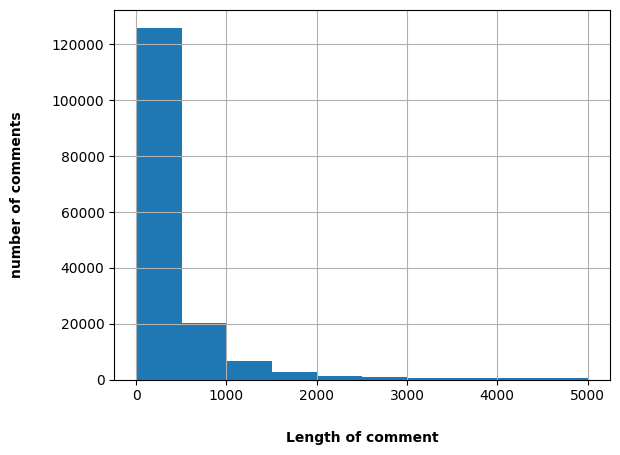

In [262]:
histogram = lens.hist();
histogram.set_xlabel("Length of comment", labelpad=20, weight='bold', size=10)
histogram.set_ylabel("number of comments", labelpad=20, weight='bold', size=10)

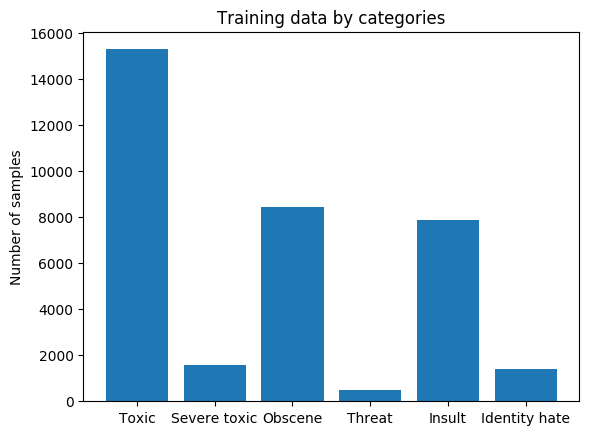

In [263]:
objects = ('Toxic', 'Severe toxic', 'Obscene', 'Threat', 'Insult', 'Identity hate')
y_pos = np.arange(len(objects))
performance = [15294, 1595, 8449, 478, 7877, 1405]

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Number of samples')
plt.title('Training data by categories')

plt.show()

In [264]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data['none'] = 1 - train_data[label_cols].max(axis=1)
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [265]:
len(train_data), len(test_data)

(159571, 153164)

In [266]:
train = train_data.copy()
test = test_data.copy()

In [267]:
COMMENT = 'comment_text'

In [268]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [220]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [77]:
vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=3, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words=None, strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x12c1ba510>, use_idf=1,
                vocabulary=None)

In [78]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

In [87]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [289]:
x = trn_term_doc
test_x = test_term_doc

In [85]:
preds = np.zeros((len(test), len(label_cols)))

In [301]:
def extract_res(prediction_results):
    return prediction_results.loc[prediction_results['id'].isin(test_id)]

test_id = test_label.loc[test_label['toxic'] != -1]['id']
prediction_results = extract_res(prediction_results)
prediction_results.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000,63978.000000
mean,0.133354,0.007943,0.062776,0.002327,0.049943,0.007270
std,0.286857,0.064690,0.207254,0.039244,0.172027,0.062928
min,0.000007,0.000030,0.000054,0.000005,0.000009,0.000009
25%,0.002670,0.000203,0.001512,0.000084,0.001245,0.000264
50%,0.007352,0.000324,0.002621,0.000105,0.002578,0.000374
75%,0.044140,0.000613,0.006590,0.000157,0.007545,0.000685
max,1.000000,0.999951,1.000000,0.999977,1.000000,1.000000


In [269]:
for i, j in enumerate(label_cols):
    print('fit', j)
    m, r = get_mdl(train[j], m)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit severe_toxic


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit obscene


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit threat
fit insult


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit identity_hate


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [104]:
evaluation_data = test_label[test_label.toxic != -1]
evaluation_data.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0


In [99]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
# submission.to_csv('submission.csv', index=False)
prediction_results = submission.copy()
prediction_results.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,0.199699,0.012875,0.112330,0.002492,0.082826,0.010945
std,0.351172,0.081021,0.278235,0.039260,0.224174,0.078703
min,0.000007,0.000010,0.000054,0.000004,0.000009,0.000008
25%,0.003005,0.000214,0.001611,0.000086,0.001355,0.000274
50%,0.009418,0.000357,0.002990,0.000109,0.003013,0.000403
75%,0.160954,0.000838,0.014028,0.000175,0.015212,0.000907
max,1.000000,0.999979,1.000000,0.999997,1.000000,1.000000


In [308]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def plot_roc_curve(evaluation_data, prediction_results):
    for i, col in enumerate(evaluation_data.columns):
        eval_col = evaluation_data[col].values.tolist()
        pred_col = prediction_results[col].values.tolist()        
        plt.subplot(3, 2, i + 1)
        label = f"{col} - ROC curve"
        lr_fpr, lr_tpr, _ = roc_curve(eval_col, pred_col)
        pyplot.plot(lr_fpr, lr_tpr, marker='.', label=label)
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.legend()

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    
    
def evaluate(evaluation_data, prediction_results, roc_curve=False):
    """ 
    Mean ROC over all columns
    """
    evaluation_data = evaluation_data.drop('id', 1)
    evaluation_data.head()
    prediction_results = prediction_results.drop('id', 1)
    n = 0
    score = 0
    for (name, prediction) in prediction_results.iteritems():    
        evaluation = evaluation_data[name].values.tolist()
        score += roc_auc_score(evaluation, prediction)
        n += 1
        
    if roc_curve:
        plot_roc_curve(evaluation_data, prediction_results)
    
    score /= n
    print('ROC score: %.5f'%(score))

ROC score: 0.97630


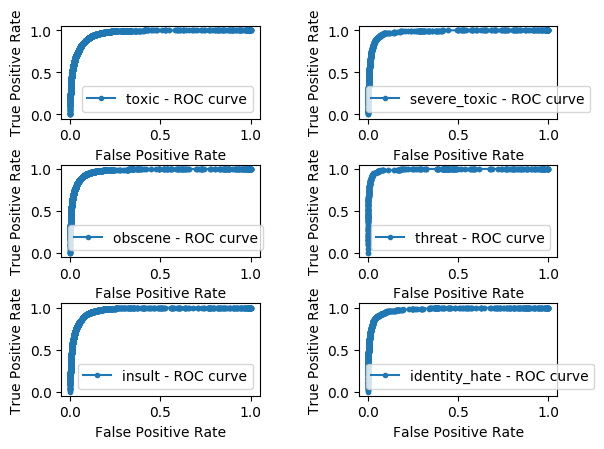

In [295]:
# Mean ROC over all columns
evaluate(evaluation_data, prediction_results, roc_curve=True)

In [292]:
def get_mdl(y, m):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r


m = [None for _ in range(len(label_cols))]
r = [None for _ in range(len(label_cols))]

for i, j in enumerate(label_cols):
    print('fit', j)
    base = LogisticRegression(C=4, dual=False)
    m[i], r[i] = get_mdl(train[j], base)
    preds[:,i] = m[i].predict_proba(test_x.multiply(r[i]))[:,1]

fit toxic


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit severe_toxic


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit obscene


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit threat
fit insult


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit identity_hate


/Users/nguyengiang/miniconda3/envs/QnA/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [328]:
def predict_from_text(text):
    preds = np.zeros((len(label_cols)))
    spare_matrix = vec.transform([text])
    for i in range(len(label_cols)):    
        preds[i] = m[i].predict_proba(spare_matrix.multiply(r[i]))[:,1]
    return preds

preds = predict_from_text('I love you')

def preds_to_json(preds):
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    res = {}
    for i, j in enumerate(label_cols):
        res[j] = preds[i]
    return res

preds_to_json(preds)

{'toxic': 0.006743109256195624,
 'severe_toxic': 0.000332819913258486,
 'obscene': 0.0026678250549461873,
 'threat': 0.00012128601364098639,
 'insult': 0.004486947159606703,
 'identity_hate': 0.021379224492927697}

ROC score: 0.97630


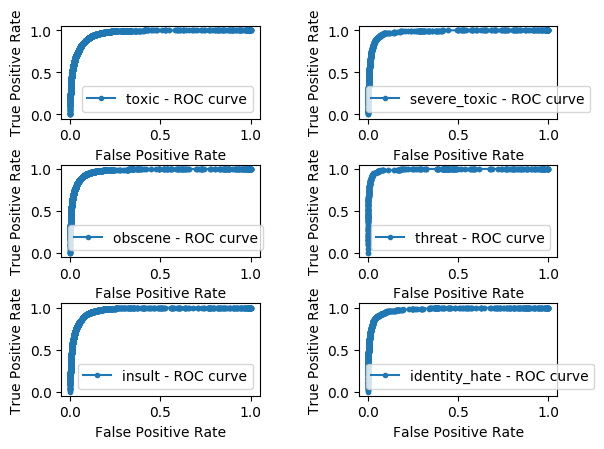

In [313]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
prediction_resulst = extract_res(submission)
evaluate(evaluation_data, prediction_resulst, roc_curve=True)

In [333]:
def save_models(path, m):
    for i, filename in enumerate(label_cols):
        pickle_out = open(path + f"/{filename}.pickle", "wb")
        pickle.dump(m[i], pickle_out)
        pickle_out.close()

def load_models(path):
    models = [None for _ in range(len(label_cols))]
    for i, filename in enumerate(label_cols):
        pickle_in = open(path + f"/{filename}.pickle","rb")
        models[i] = pickle.load(pickle_in)
        pickle_in.close()
    return models

def predict_from_text(text, m):
    preds = np.zeros((len(label_cols)))
    spare_matrix = vec.transform([text])
    for i in range(len(label_cols)):    
        preds[i] = m[i].predict_proba(spare_matrix.multiply(r[i]))[:,1]
    return preds

In [340]:
!pwd
save_models('../models', m)
models = load_models('../models')

/Users/nguyengiang/workspace/toxic-comment


FileNotFoundError: [Errno 2] No such file or directory: '../models/toxic.pickle'